In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt

In [2]:
import os
import function_training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import json

import numpy as np
import tensorflow as tf

from dataLoader import AnyDataset
import function_training
from function_training import confusion_matrix
from config import MLP_model,hyperparameters, args, CNN_model

numBands=100
bands_type="spin up"

import xgboost as xgb

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
## # step 1. prepare dataset
# def json2inputlabel(data_json, bands_type="spin up"):
#     _bands_type = {"spin up": "spin_up_bands",
#                    "spin down": "spin_down_bands",
#                    "soc": "soc_bands"}
#     data_input_np = np.array(data_json[_bands_type[bands_type]]) # 100 x 400
#     # data_input_np = np.array(data_json[_bands_type[bands_type]]).flataten().T # 40000x1
#     data_label_np = np.array([data_json["new_label"]])
#     # data_label_np = np.array([data_json["layers_num"]])

#     return data_input_np, data_label_np

# step 1. prepare dataset
debug=0
def json2inputlabel(data_json, bands_type="spin up", gamma=True, layergroup_input=True):
    _bands_type = {"spin up": "spin_up_bands",
                   "spin down": "spin_down_bands",
                   "soc": "soc_bands"}
    
#     ## Original input bands
#     data_input_np = np.array(data_json[_bands_type[bands_type]])
    
    ## Trial: input 40*400 and take gamma point only
    data_input_np = np.array(data_json[_bands_type[bands_type]])
    
    if gamma:
        for pts in data_json["k_labels"]:
    #         print (pts[0], pts[1])
            if pts[0] == 'G':
                if debug:
                    print (pts[0], pts[1])

    #             if pts[1] != 0:
    #                 print (f'({pts[0]}, {pts[1]}) || layers num: {data_json["layers_num"]}')
                gamma_point = pts[1]
                break


        data_input_np = data_input_np[:,gamma_point]
        if debug:
            print (f'data_input_np: {data_input_np.shape}')
            
    if layergroup_input:
        layergroup_number_input_np = np.array([data_json["layergroup_number"]])
        data_input_np = np.concatenate((data_input_np, layergroup_number_input_np), axis=None)
    ## labels
    data_label_np = np.array([data_json["new_label"]])

    return data_input_np, data_label_np

#take data and set batch size here
train_dataset = AnyDataset("list/actual/train_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=True)
test_dataset = AnyDataset("list/actual/test_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=False)
train_loader = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs, train_dataset.data_labels)).shuffle(train_dataset.len).batch(hyperparameters['batch_size'])
test_loader = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(hyperparameters['batch_size'])


Loading test set: 100%|██████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 206.75it/s]

Metal device set to: Apple M1 Pro


In [4]:
train_loader2 = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs,train_dataset.data_labels)).shuffle(train_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in train_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])

#     predict = np.argmax(model.predict(element), axis=-1)
#     label = np.array(labels).flatten()
    break

In [5]:
shape = element.numpy().shape
print (shape)
try:
    shape[2]
    element_flatten2D_train = element.numpy().reshape(shape[0],shape[1]*shape[2])
except IndexError:
    element_flatten2D_train = element.numpy().reshape(shape[0],shape[1])
# element_flatten2D_train = element.numpy().reshape(shape[0],shape[1]*shape[2])
labels1D_train = labels.numpy().flatten()

dtrain = xgb.DMatrix(element_flatten2D_train, label=labels1D_train)

(1000, 41)


In [6]:
test_loader2 = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in test_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])

#     predict = np.argmax(model.predict(element), axis=-1)
#     label = np.array(labels).flatten()
    break

shape = element.numpy().shape
try:
    shape[2]
    element_flatten2D_test = element.numpy().reshape(shape[0],shape[1]*shape[2])
except IndexError:
    element_flatten2D_test = element.numpy().reshape(shape[0],shape[1])
# shape = element.numpy().shape
# element_flatten2D_test = element.numpy().reshape(shape[0],shape[1])
# element_flatten2D_test = element.numpy().reshape(shape[0],shape[1]*shape[2])
labels1D_test = labels.numpy().flatten()

dtest = xgb.DMatrix(element_flatten2D_test, label=labels1D_test)

In [7]:
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
###
# advanced: start from a initial base prediction
#
print('start running example to start from a initial prediction')
# specify parameters via map, definition are same as c++ version
param = {'max_depth': 5, 'eta': 0.2, 'lambda':0, 'alpha':0, 'num_class': 9, 'objective':'multi:softmax', 'sampling_method':'gradient_based'}
# param = {'max_depth': 30, 'eta': 0.002, 'lambda':0, 'alpha':0, 'num_class': 9, 'objective':'multi:softmax', 'sampling_method':'gradient_based'}
# param = {'max_depth': 30, 'eta': 0.002, 'lambda':0, 'alpha':0, 'num_class': 5, 'objective':'multi:softmax'}
# train xgboost for 1 round
bst = xgb.train(param, dtrain, 3500, watchlist, early_stopping_rounds=50)
# Note: we need the margin value instead of transformed prediction in
# set_base_margin
# do predict with output_margin=True, will always give you margin values
# before logistic transformation
ptrain = bst.predict(dtrain)
ptest = bst.predict(dtest)

start running example to start from a initial prediction
[13:58:49] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-mlogloss:1.87658	train-mlogloss:1.75525
[1]	eval-mlogloss:1.71579	train-mlogloss:1.49572
[2]	eval-mlogloss:1.58465	train-mlogloss:1.29346
[3]	eval-mlogloss:1.49569	train-mlogloss:1.14608
[4]	eval-mlogloss:1.43101	train-mlogloss:1.02581
[5]	eval-mlogloss:1.36162	train-mlogloss:0.92833
[6]	eval-mlogloss:1.31766	train-mlogloss:0.84420
[7]	eval-mlogloss:1.26048	train-mlogloss:0.76496
[8]	eval-mlogloss:1.21703	train-mlogloss:0.70420
[9]	eval-mlogloss:1.18532	train-mlogloss:0.65452
[10]	eval-mlogloss:1.15841	train-mlogloss:0.60793
[11]	eval-mlogloss:1.13329	train-mlogloss:0.56526
[12]	eval-mlogloss:1.11802	train-mlogl

[156]	eval-mlogloss:0.95978	train-mlogloss:0.01328
[157]	eval-mlogloss:0.95899	train-mlogloss:0.01320
[158]	eval-mlogloss:0.96006	train-mlogloss:0.01310
[159]	eval-mlogloss:0.96071	train-mlogloss:0.01303
[160]	eval-mlogloss:0.96126	train-mlogloss:0.01295
[161]	eval-mlogloss:0.96058	train-mlogloss:0.01287
[162]	eval-mlogloss:0.96194	train-mlogloss:0.01279
[163]	eval-mlogloss:0.96307	train-mlogloss:0.01270
[164]	eval-mlogloss:0.96386	train-mlogloss:0.01263
[165]	eval-mlogloss:0.96334	train-mlogloss:0.01256
[166]	eval-mlogloss:0.96364	train-mlogloss:0.01249
[167]	eval-mlogloss:0.96408	train-mlogloss:0.01242
[168]	eval-mlogloss:0.96578	train-mlogloss:0.01233
[169]	eval-mlogloss:0.96572	train-mlogloss:0.01227
[170]	eval-mlogloss:0.96559	train-mlogloss:0.01219
[171]	eval-mlogloss:0.96532	train-mlogloss:0.01212
[172]	eval-mlogloss:0.96479	train-mlogloss:0.01206
[173]	eval-mlogloss:0.96577	train-mlogloss:0.01200
[174]	eval-mlogloss:0.96538	train-mlogloss:0.01194
[175]	eval-mlogloss:0.96508	tra

[317]	eval-mlogloss:0.98272	train-mlogloss:0.00798
[318]	eval-mlogloss:0.98258	train-mlogloss:0.00797
[319]	eval-mlogloss:0.98262	train-mlogloss:0.00796
[320]	eval-mlogloss:0.98266	train-mlogloss:0.00795
[321]	eval-mlogloss:0.98235	train-mlogloss:0.00793
[322]	eval-mlogloss:0.98244	train-mlogloss:0.00792
[323]	eval-mlogloss:0.98211	train-mlogloss:0.00791
[324]	eval-mlogloss:0.98295	train-mlogloss:0.00790
[325]	eval-mlogloss:0.98272	train-mlogloss:0.00789
[326]	eval-mlogloss:0.98240	train-mlogloss:0.00788
[327]	eval-mlogloss:0.98311	train-mlogloss:0.00787
[328]	eval-mlogloss:0.98335	train-mlogloss:0.00785
[329]	eval-mlogloss:0.98357	train-mlogloss:0.00784
[330]	eval-mlogloss:0.98366	train-mlogloss:0.00783
[331]	eval-mlogloss:0.98333	train-mlogloss:0.00782
[332]	eval-mlogloss:0.98370	train-mlogloss:0.00781
[333]	eval-mlogloss:0.98385	train-mlogloss:0.00780
[334]	eval-mlogloss:0.98403	train-mlogloss:0.00779
[335]	eval-mlogloss:0.98435	train-mlogloss:0.00778
[336]	eval-mlogloss:0.98430	tra

[478]	eval-mlogloss:0.99790	train-mlogloss:0.00678
[479]	eval-mlogloss:0.99858	train-mlogloss:0.00677
[480]	eval-mlogloss:0.99819	train-mlogloss:0.00677
[481]	eval-mlogloss:0.99870	train-mlogloss:0.00677
[482]	eval-mlogloss:0.99821	train-mlogloss:0.00676
[483]	eval-mlogloss:0.99774	train-mlogloss:0.00676
[484]	eval-mlogloss:0.99787	train-mlogloss:0.00675
[485]	eval-mlogloss:0.99802	train-mlogloss:0.00675
[486]	eval-mlogloss:0.99810	train-mlogloss:0.00674
[487]	eval-mlogloss:0.99769	train-mlogloss:0.00673
[488]	eval-mlogloss:0.99795	train-mlogloss:0.00673
[489]	eval-mlogloss:0.99721	train-mlogloss:0.00673
[490]	eval-mlogloss:0.99751	train-mlogloss:0.00672
[491]	eval-mlogloss:0.99766	train-mlogloss:0.00672
[492]	eval-mlogloss:0.99784	train-mlogloss:0.00671
[493]	eval-mlogloss:0.99735	train-mlogloss:0.00671
[494]	eval-mlogloss:0.99766	train-mlogloss:0.00671
[495]	eval-mlogloss:0.99823	train-mlogloss:0.00670
[496]	eval-mlogloss:0.99780	train-mlogloss:0.00669
[497]	eval-mlogloss:0.99839	tra

[639]	eval-mlogloss:1.00162	train-mlogloss:0.00617
[640]	eval-mlogloss:1.00156	train-mlogloss:0.00617
[641]	eval-mlogloss:1.00147	train-mlogloss:0.00616
[642]	eval-mlogloss:1.00149	train-mlogloss:0.00616
[643]	eval-mlogloss:1.00176	train-mlogloss:0.00616
[644]	eval-mlogloss:1.00162	train-mlogloss:0.00615
[645]	eval-mlogloss:1.00113	train-mlogloss:0.00615
[646]	eval-mlogloss:1.00140	train-mlogloss:0.00615
[647]	eval-mlogloss:1.00148	train-mlogloss:0.00615
[648]	eval-mlogloss:1.00160	train-mlogloss:0.00614
[649]	eval-mlogloss:1.00183	train-mlogloss:0.00614
[650]	eval-mlogloss:1.00181	train-mlogloss:0.00614
[651]	eval-mlogloss:1.00160	train-mlogloss:0.00613
[652]	eval-mlogloss:1.00181	train-mlogloss:0.00613
[653]	eval-mlogloss:1.00176	train-mlogloss:0.00613
[654]	eval-mlogloss:1.00167	train-mlogloss:0.00613
[655]	eval-mlogloss:1.00152	train-mlogloss:0.00612
[656]	eval-mlogloss:1.00144	train-mlogloss:0.00612
[657]	eval-mlogloss:1.00139	train-mlogloss:0.00612
[658]	eval-mlogloss:1.00128	tra

[800]	eval-mlogloss:1.00488	train-mlogloss:0.00581
[801]	eval-mlogloss:1.00486	train-mlogloss:0.00580
[802]	eval-mlogloss:1.00506	train-mlogloss:0.00580
[803]	eval-mlogloss:1.00487	train-mlogloss:0.00580
[804]	eval-mlogloss:1.00498	train-mlogloss:0.00580
[805]	eval-mlogloss:1.00487	train-mlogloss:0.00579
[806]	eval-mlogloss:1.00467	train-mlogloss:0.00579
[807]	eval-mlogloss:1.00516	train-mlogloss:0.00579
[808]	eval-mlogloss:1.00515	train-mlogloss:0.00579
[809]	eval-mlogloss:1.00510	train-mlogloss:0.00579
[810]	eval-mlogloss:1.00515	train-mlogloss:0.00579
[811]	eval-mlogloss:1.00508	train-mlogloss:0.00579
[812]	eval-mlogloss:1.00503	train-mlogloss:0.00578
[813]	eval-mlogloss:1.00488	train-mlogloss:0.00578
[814]	eval-mlogloss:1.00478	train-mlogloss:0.00578
[815]	eval-mlogloss:1.00459	train-mlogloss:0.00578
[816]	eval-mlogloss:1.00451	train-mlogloss:0.00577
[817]	eval-mlogloss:1.00442	train-mlogloss:0.00577
[818]	eval-mlogloss:1.00445	train-mlogloss:0.00577
[819]	eval-mlogloss:1.00447	tra

[961]	eval-mlogloss:1.00769	train-mlogloss:0.00558
[962]	eval-mlogloss:1.00794	train-mlogloss:0.00558
[963]	eval-mlogloss:1.00820	train-mlogloss:0.00557
[964]	eval-mlogloss:1.00814	train-mlogloss:0.00557
[965]	eval-mlogloss:1.00773	train-mlogloss:0.00557
[966]	eval-mlogloss:1.00772	train-mlogloss:0.00557
[967]	eval-mlogloss:1.00770	train-mlogloss:0.00557
[968]	eval-mlogloss:1.00777	train-mlogloss:0.00557
[969]	eval-mlogloss:1.00779	train-mlogloss:0.00557
[970]	eval-mlogloss:1.00806	train-mlogloss:0.00557
[971]	eval-mlogloss:1.00814	train-mlogloss:0.00557
[972]	eval-mlogloss:1.00846	train-mlogloss:0.00556
[973]	eval-mlogloss:1.00840	train-mlogloss:0.00556
[974]	eval-mlogloss:1.00844	train-mlogloss:0.00556
[975]	eval-mlogloss:1.00839	train-mlogloss:0.00556
[976]	eval-mlogloss:1.00830	train-mlogloss:0.00556
[977]	eval-mlogloss:1.00827	train-mlogloss:0.00556
[978]	eval-mlogloss:1.00794	train-mlogloss:0.00556
[979]	eval-mlogloss:1.00804	train-mlogloss:0.00556
[980]	eval-mlogloss:1.00808	tra

[1120]	eval-mlogloss:1.00919	train-mlogloss:0.00542
[1121]	eval-mlogloss:1.00919	train-mlogloss:0.00542
[1122]	eval-mlogloss:1.00919	train-mlogloss:0.00542
[1123]	eval-mlogloss:1.00952	train-mlogloss:0.00542
[1124]	eval-mlogloss:1.00919	train-mlogloss:0.00542
[1125]	eval-mlogloss:1.00951	train-mlogloss:0.00541
[1126]	eval-mlogloss:1.00935	train-mlogloss:0.00541
[1127]	eval-mlogloss:1.00937	train-mlogloss:0.00541
[1128]	eval-mlogloss:1.00949	train-mlogloss:0.00541
[1129]	eval-mlogloss:1.00932	train-mlogloss:0.00541
[1130]	eval-mlogloss:1.00912	train-mlogloss:0.00541
[1131]	eval-mlogloss:1.00902	train-mlogloss:0.00541
[1132]	eval-mlogloss:1.00904	train-mlogloss:0.00541
[1133]	eval-mlogloss:1.00943	train-mlogloss:0.00541
[1134]	eval-mlogloss:1.00939	train-mlogloss:0.00541
[1135]	eval-mlogloss:1.00933	train-mlogloss:0.00541
[1136]	eval-mlogloss:1.00927	train-mlogloss:0.00541
[1137]	eval-mlogloss:1.00945	train-mlogloss:0.00541
[1138]	eval-mlogloss:1.00934	train-mlogloss:0.00540
[1139]	eval-

[1278]	eval-mlogloss:1.01074	train-mlogloss:0.00530
[1279]	eval-mlogloss:1.01063	train-mlogloss:0.00530
[1280]	eval-mlogloss:1.01070	train-mlogloss:0.00530
[1281]	eval-mlogloss:1.01052	train-mlogloss:0.00530
[1282]	eval-mlogloss:1.01059	train-mlogloss:0.00530
[1283]	eval-mlogloss:1.01032	train-mlogloss:0.00530
[1284]	eval-mlogloss:1.01037	train-mlogloss:0.00530
[1285]	eval-mlogloss:1.01026	train-mlogloss:0.00530
[1286]	eval-mlogloss:1.01040	train-mlogloss:0.00530
[1287]	eval-mlogloss:1.01060	train-mlogloss:0.00529
[1288]	eval-mlogloss:1.01090	train-mlogloss:0.00529
[1289]	eval-mlogloss:1.01067	train-mlogloss:0.00529
[1290]	eval-mlogloss:1.01077	train-mlogloss:0.00529
[1291]	eval-mlogloss:1.01085	train-mlogloss:0.00529
[1292]	eval-mlogloss:1.01082	train-mlogloss:0.00529
[1293]	eval-mlogloss:1.01070	train-mlogloss:0.00529
[1294]	eval-mlogloss:1.01095	train-mlogloss:0.00529
[1295]	eval-mlogloss:1.01069	train-mlogloss:0.00529
[1296]	eval-mlogloss:1.01104	train-mlogloss:0.00529
[1297]	eval-

[1436]	eval-mlogloss:1.01217	train-mlogloss:0.00520
[1437]	eval-mlogloss:1.01213	train-mlogloss:0.00520
[1438]	eval-mlogloss:1.01209	train-mlogloss:0.00520
[1439]	eval-mlogloss:1.01226	train-mlogloss:0.00520
[1440]	eval-mlogloss:1.01211	train-mlogloss:0.00520
[1441]	eval-mlogloss:1.01227	train-mlogloss:0.00520
[1442]	eval-mlogloss:1.01220	train-mlogloss:0.00520
[1443]	eval-mlogloss:1.01240	train-mlogloss:0.00520
[1444]	eval-mlogloss:1.01235	train-mlogloss:0.00520
[1445]	eval-mlogloss:1.01250	train-mlogloss:0.00520
[1446]	eval-mlogloss:1.01217	train-mlogloss:0.00520
[1447]	eval-mlogloss:1.01235	train-mlogloss:0.00519
[1448]	eval-mlogloss:1.01205	train-mlogloss:0.00519
[1449]	eval-mlogloss:1.01217	train-mlogloss:0.00519
[1450]	eval-mlogloss:1.01227	train-mlogloss:0.00519
[1451]	eval-mlogloss:1.01225	train-mlogloss:0.00519
[1452]	eval-mlogloss:1.01220	train-mlogloss:0.00519
[1453]	eval-mlogloss:1.01218	train-mlogloss:0.00519
[1454]	eval-mlogloss:1.01237	train-mlogloss:0.00519
[1455]	eval-

[1594]	eval-mlogloss:1.01272	train-mlogloss:0.00511
[1595]	eval-mlogloss:1.01299	train-mlogloss:0.00511
[1596]	eval-mlogloss:1.01279	train-mlogloss:0.00511
[1597]	eval-mlogloss:1.01308	train-mlogloss:0.00511
[1598]	eval-mlogloss:1.01284	train-mlogloss:0.00511
[1599]	eval-mlogloss:1.01306	train-mlogloss:0.00511
[1600]	eval-mlogloss:1.01331	train-mlogloss:0.00511
[1601]	eval-mlogloss:1.01322	train-mlogloss:0.00511
[1602]	eval-mlogloss:1.01309	train-mlogloss:0.00511
[1603]	eval-mlogloss:1.01326	train-mlogloss:0.00511
[1604]	eval-mlogloss:1.01312	train-mlogloss:0.00511
[1605]	eval-mlogloss:1.01320	train-mlogloss:0.00511
[1606]	eval-mlogloss:1.01296	train-mlogloss:0.00511
[1607]	eval-mlogloss:1.01290	train-mlogloss:0.00511
[1608]	eval-mlogloss:1.01296	train-mlogloss:0.00511
[1609]	eval-mlogloss:1.01312	train-mlogloss:0.00511
[1610]	eval-mlogloss:1.01316	train-mlogloss:0.00511
[1611]	eval-mlogloss:1.01311	train-mlogloss:0.00511
[1612]	eval-mlogloss:1.01340	train-mlogloss:0.00510
[1613]	eval-

[1752]	eval-mlogloss:1.01568	train-mlogloss:0.00504
[1753]	eval-mlogloss:1.01570	train-mlogloss:0.00504
[1754]	eval-mlogloss:1.01578	train-mlogloss:0.00504
[1755]	eval-mlogloss:1.01577	train-mlogloss:0.00504
[1756]	eval-mlogloss:1.01585	train-mlogloss:0.00504
[1757]	eval-mlogloss:1.01587	train-mlogloss:0.00504
[1758]	eval-mlogloss:1.01582	train-mlogloss:0.00503
[1759]	eval-mlogloss:1.01601	train-mlogloss:0.00503
[1760]	eval-mlogloss:1.01589	train-mlogloss:0.00503
[1761]	eval-mlogloss:1.01599	train-mlogloss:0.00503
[1762]	eval-mlogloss:1.01600	train-mlogloss:0.00503
[1763]	eval-mlogloss:1.01600	train-mlogloss:0.00503
[1764]	eval-mlogloss:1.01596	train-mlogloss:0.00503
[1765]	eval-mlogloss:1.01567	train-mlogloss:0.00503
[1766]	eval-mlogloss:1.01595	train-mlogloss:0.00503
[1767]	eval-mlogloss:1.01580	train-mlogloss:0.00503
[1768]	eval-mlogloss:1.01594	train-mlogloss:0.00503
[1769]	eval-mlogloss:1.01586	train-mlogloss:0.00503
[1770]	eval-mlogloss:1.01579	train-mlogloss:0.00503
[1771]	eval-

[1910]	eval-mlogloss:1.01743	train-mlogloss:0.00497
[1911]	eval-mlogloss:1.01728	train-mlogloss:0.00497
[1912]	eval-mlogloss:1.01737	train-mlogloss:0.00497
[1913]	eval-mlogloss:1.01731	train-mlogloss:0.00497
[1914]	eval-mlogloss:1.01738	train-mlogloss:0.00497
[1915]	eval-mlogloss:1.01731	train-mlogloss:0.00497
[1916]	eval-mlogloss:1.01754	train-mlogloss:0.00497
[1917]	eval-mlogloss:1.01731	train-mlogloss:0.00497
[1918]	eval-mlogloss:1.01748	train-mlogloss:0.00497
[1919]	eval-mlogloss:1.01747	train-mlogloss:0.00497
[1920]	eval-mlogloss:1.01749	train-mlogloss:0.00497
[1921]	eval-mlogloss:1.01751	train-mlogloss:0.00497
[1922]	eval-mlogloss:1.01751	train-mlogloss:0.00497
[1923]	eval-mlogloss:1.01750	train-mlogloss:0.00497
[1924]	eval-mlogloss:1.01755	train-mlogloss:0.00497
[1925]	eval-mlogloss:1.01750	train-mlogloss:0.00497
[1926]	eval-mlogloss:1.01752	train-mlogloss:0.00497
[1927]	eval-mlogloss:1.01750	train-mlogloss:0.00497
[1928]	eval-mlogloss:1.01741	train-mlogloss:0.00497
[1929]	eval-

[2068]	eval-mlogloss:1.01805	train-mlogloss:0.00492
[2069]	eval-mlogloss:1.01808	train-mlogloss:0.00492
[2070]	eval-mlogloss:1.01801	train-mlogloss:0.00492
[2071]	eval-mlogloss:1.01799	train-mlogloss:0.00492
[2072]	eval-mlogloss:1.01798	train-mlogloss:0.00492
[2073]	eval-mlogloss:1.01794	train-mlogloss:0.00492
[2074]	eval-mlogloss:1.01806	train-mlogloss:0.00492
[2075]	eval-mlogloss:1.01800	train-mlogloss:0.00492
[2076]	eval-mlogloss:1.01806	train-mlogloss:0.00492
[2077]	eval-mlogloss:1.01796	train-mlogloss:0.00492
[2078]	eval-mlogloss:1.01808	train-mlogloss:0.00492
[2079]	eval-mlogloss:1.01806	train-mlogloss:0.00492
[2080]	eval-mlogloss:1.01814	train-mlogloss:0.00492
[2081]	eval-mlogloss:1.01802	train-mlogloss:0.00491
[2082]	eval-mlogloss:1.01812	train-mlogloss:0.00491
[2083]	eval-mlogloss:1.01808	train-mlogloss:0.00491
[2084]	eval-mlogloss:1.01814	train-mlogloss:0.00491
[2085]	eval-mlogloss:1.01815	train-mlogloss:0.00491
[2086]	eval-mlogloss:1.01804	train-mlogloss:0.00491
[2087]	eval-

[2226]	eval-mlogloss:1.01821	train-mlogloss:0.00487
[2227]	eval-mlogloss:1.01801	train-mlogloss:0.00487
[2228]	eval-mlogloss:1.01815	train-mlogloss:0.00487
[2229]	eval-mlogloss:1.01798	train-mlogloss:0.00487
[2230]	eval-mlogloss:1.01804	train-mlogloss:0.00487
[2231]	eval-mlogloss:1.01792	train-mlogloss:0.00487
[2232]	eval-mlogloss:1.01802	train-mlogloss:0.00487
[2233]	eval-mlogloss:1.01799	train-mlogloss:0.00487
[2234]	eval-mlogloss:1.01811	train-mlogloss:0.00487
[2235]	eval-mlogloss:1.01797	train-mlogloss:0.00487
[2236]	eval-mlogloss:1.01814	train-mlogloss:0.00487
[2237]	eval-mlogloss:1.01800	train-mlogloss:0.00487
[2238]	eval-mlogloss:1.01814	train-mlogloss:0.00487
[2239]	eval-mlogloss:1.01798	train-mlogloss:0.00487
[2240]	eval-mlogloss:1.01812	train-mlogloss:0.00487
[2241]	eval-mlogloss:1.01798	train-mlogloss:0.00487
[2242]	eval-mlogloss:1.01800	train-mlogloss:0.00487
[2243]	eval-mlogloss:1.01786	train-mlogloss:0.00487
[2244]	eval-mlogloss:1.01783	train-mlogloss:0.00487
[2245]	eval-

[2384]	eval-mlogloss:1.01713	train-mlogloss:0.00483
[2385]	eval-mlogloss:1.01713	train-mlogloss:0.00482
[2386]	eval-mlogloss:1.01711	train-mlogloss:0.00482
[2387]	eval-mlogloss:1.01713	train-mlogloss:0.00482
[2388]	eval-mlogloss:1.01711	train-mlogloss:0.00482
[2389]	eval-mlogloss:1.01711	train-mlogloss:0.00482
[2390]	eval-mlogloss:1.01717	train-mlogloss:0.00482
[2391]	eval-mlogloss:1.01708	train-mlogloss:0.00482
[2392]	eval-mlogloss:1.01717	train-mlogloss:0.00482
[2393]	eval-mlogloss:1.01711	train-mlogloss:0.00482
[2394]	eval-mlogloss:1.01698	train-mlogloss:0.00482
[2395]	eval-mlogloss:1.01706	train-mlogloss:0.00482
[2396]	eval-mlogloss:1.01708	train-mlogloss:0.00482
[2397]	eval-mlogloss:1.01712	train-mlogloss:0.00482
[2398]	eval-mlogloss:1.01706	train-mlogloss:0.00482
[2399]	eval-mlogloss:1.01722	train-mlogloss:0.00482
[2400]	eval-mlogloss:1.01713	train-mlogloss:0.00482
[2401]	eval-mlogloss:1.01711	train-mlogloss:0.00482
[2402]	eval-mlogloss:1.01716	train-mlogloss:0.00482
[2403]	eval-

[2542]	eval-mlogloss:1.01679	train-mlogloss:0.00478
[2543]	eval-mlogloss:1.01686	train-mlogloss:0.00478
[2544]	eval-mlogloss:1.01675	train-mlogloss:0.00478
[2545]	eval-mlogloss:1.01681	train-mlogloss:0.00478
[2546]	eval-mlogloss:1.01677	train-mlogloss:0.00478
[2547]	eval-mlogloss:1.01674	train-mlogloss:0.00478
[2548]	eval-mlogloss:1.01675	train-mlogloss:0.00478
[2549]	eval-mlogloss:1.01676	train-mlogloss:0.00478
[2550]	eval-mlogloss:1.01683	train-mlogloss:0.00478
[2551]	eval-mlogloss:1.01675	train-mlogloss:0.00478
[2552]	eval-mlogloss:1.01667	train-mlogloss:0.00478
[2553]	eval-mlogloss:1.01663	train-mlogloss:0.00478
[2554]	eval-mlogloss:1.01674	train-mlogloss:0.00478
[2555]	eval-mlogloss:1.01667	train-mlogloss:0.00478
[2556]	eval-mlogloss:1.01670	train-mlogloss:0.00478
[2557]	eval-mlogloss:1.01669	train-mlogloss:0.00478
[2558]	eval-mlogloss:1.01664	train-mlogloss:0.00478
[2559]	eval-mlogloss:1.01668	train-mlogloss:0.00478
[2560]	eval-mlogloss:1.01662	train-mlogloss:0.00478
[2561]	eval-

[2700]	eval-mlogloss:1.01592	train-mlogloss:0.00474
[2701]	eval-mlogloss:1.01614	train-mlogloss:0.00474
[2702]	eval-mlogloss:1.01605	train-mlogloss:0.00474
[2703]	eval-mlogloss:1.01609	train-mlogloss:0.00474
[2704]	eval-mlogloss:1.01602	train-mlogloss:0.00474
[2705]	eval-mlogloss:1.01609	train-mlogloss:0.00474
[2706]	eval-mlogloss:1.01603	train-mlogloss:0.00474
[2707]	eval-mlogloss:1.01619	train-mlogloss:0.00474
[2708]	eval-mlogloss:1.01604	train-mlogloss:0.00474
[2709]	eval-mlogloss:1.01615	train-mlogloss:0.00474
[2710]	eval-mlogloss:1.01613	train-mlogloss:0.00474
[2711]	eval-mlogloss:1.01617	train-mlogloss:0.00474
[2712]	eval-mlogloss:1.01614	train-mlogloss:0.00474
[2713]	eval-mlogloss:1.01622	train-mlogloss:0.00474
[2714]	eval-mlogloss:1.01612	train-mlogloss:0.00474
[2715]	eval-mlogloss:1.01615	train-mlogloss:0.00474
[2716]	eval-mlogloss:1.01611	train-mlogloss:0.00474
[2717]	eval-mlogloss:1.01606	train-mlogloss:0.00474
[2718]	eval-mlogloss:1.01617	train-mlogloss:0.00474
[2719]	eval-

[2858]	eval-mlogloss:1.01526	train-mlogloss:0.00470
[2859]	eval-mlogloss:1.01523	train-mlogloss:0.00470
[2860]	eval-mlogloss:1.01511	train-mlogloss:0.00470
[2861]	eval-mlogloss:1.01525	train-mlogloss:0.00470
[2862]	eval-mlogloss:1.01520	train-mlogloss:0.00470
[2863]	eval-mlogloss:1.01523	train-mlogloss:0.00470
[2864]	eval-mlogloss:1.01524	train-mlogloss:0.00470
[2865]	eval-mlogloss:1.01531	train-mlogloss:0.00470
[2866]	eval-mlogloss:1.01523	train-mlogloss:0.00470
[2867]	eval-mlogloss:1.01529	train-mlogloss:0.00470
[2868]	eval-mlogloss:1.01517	train-mlogloss:0.00470
[2869]	eval-mlogloss:1.01528	train-mlogloss:0.00470
[2870]	eval-mlogloss:1.01519	train-mlogloss:0.00470
[2871]	eval-mlogloss:1.01519	train-mlogloss:0.00470
[2872]	eval-mlogloss:1.01515	train-mlogloss:0.00470
[2873]	eval-mlogloss:1.01515	train-mlogloss:0.00470
[2874]	eval-mlogloss:1.01517	train-mlogloss:0.00470
[2875]	eval-mlogloss:1.01518	train-mlogloss:0.00470
[2876]	eval-mlogloss:1.01526	train-mlogloss:0.00470
[2877]	eval-

[3016]	eval-mlogloss:1.01465	train-mlogloss:0.00467
[3017]	eval-mlogloss:1.01458	train-mlogloss:0.00467
[3018]	eval-mlogloss:1.01471	train-mlogloss:0.00467
[3019]	eval-mlogloss:1.01456	train-mlogloss:0.00467
[3020]	eval-mlogloss:1.01471	train-mlogloss:0.00467
[3021]	eval-mlogloss:1.01453	train-mlogloss:0.00467
[3022]	eval-mlogloss:1.01470	train-mlogloss:0.00467
[3023]	eval-mlogloss:1.01459	train-mlogloss:0.00467
[3024]	eval-mlogloss:1.01470	train-mlogloss:0.00467
[3025]	eval-mlogloss:1.01453	train-mlogloss:0.00467
[3026]	eval-mlogloss:1.01464	train-mlogloss:0.00467
[3027]	eval-mlogloss:1.01451	train-mlogloss:0.00467
[3028]	eval-mlogloss:1.01466	train-mlogloss:0.00467
[3029]	eval-mlogloss:1.01452	train-mlogloss:0.00467
[3030]	eval-mlogloss:1.01447	train-mlogloss:0.00467
[3031]	eval-mlogloss:1.01440	train-mlogloss:0.00467
[3032]	eval-mlogloss:1.01454	train-mlogloss:0.00467
[3033]	eval-mlogloss:1.01430	train-mlogloss:0.00467
[3034]	eval-mlogloss:1.01444	train-mlogloss:0.00466
[3035]	eval-

[3174]	eval-mlogloss:1.01414	train-mlogloss:0.00464
[3175]	eval-mlogloss:1.01410	train-mlogloss:0.00464
[3176]	eval-mlogloss:1.01414	train-mlogloss:0.00464
[3177]	eval-mlogloss:1.01409	train-mlogloss:0.00464
[3178]	eval-mlogloss:1.01419	train-mlogloss:0.00464
[3179]	eval-mlogloss:1.01407	train-mlogloss:0.00464
[3180]	eval-mlogloss:1.01419	train-mlogloss:0.00464
[3181]	eval-mlogloss:1.01413	train-mlogloss:0.00464
[3182]	eval-mlogloss:1.01424	train-mlogloss:0.00464
[3183]	eval-mlogloss:1.01415	train-mlogloss:0.00464
[3184]	eval-mlogloss:1.01425	train-mlogloss:0.00463
[3185]	eval-mlogloss:1.01414	train-mlogloss:0.00463
[3186]	eval-mlogloss:1.01420	train-mlogloss:0.00463
[3187]	eval-mlogloss:1.01414	train-mlogloss:0.00463
[3188]	eval-mlogloss:1.01433	train-mlogloss:0.00463
[3189]	eval-mlogloss:1.01412	train-mlogloss:0.00463
[3190]	eval-mlogloss:1.01416	train-mlogloss:0.00463
[3191]	eval-mlogloss:1.01411	train-mlogloss:0.00463
[3192]	eval-mlogloss:1.01404	train-mlogloss:0.00463
[3193]	eval-

[3332]	eval-mlogloss:1.01411	train-mlogloss:0.00461
[3333]	eval-mlogloss:1.01412	train-mlogloss:0.00460
[3334]	eval-mlogloss:1.01415	train-mlogloss:0.00460
[3335]	eval-mlogloss:1.01420	train-mlogloss:0.00460
[3336]	eval-mlogloss:1.01416	train-mlogloss:0.00460
[3337]	eval-mlogloss:1.01416	train-mlogloss:0.00460
[3338]	eval-mlogloss:1.01412	train-mlogloss:0.00460
[3339]	eval-mlogloss:1.01415	train-mlogloss:0.00460
[3340]	eval-mlogloss:1.01409	train-mlogloss:0.00460
[3341]	eval-mlogloss:1.01400	train-mlogloss:0.00460
[3342]	eval-mlogloss:1.01402	train-mlogloss:0.00460
[3343]	eval-mlogloss:1.01402	train-mlogloss:0.00460
[3344]	eval-mlogloss:1.01401	train-mlogloss:0.00460
[3345]	eval-mlogloss:1.01406	train-mlogloss:0.00460
[3346]	eval-mlogloss:1.01402	train-mlogloss:0.00460
[3347]	eval-mlogloss:1.01403	train-mlogloss:0.00460
[3348]	eval-mlogloss:1.01391	train-mlogloss:0.00460
[3349]	eval-mlogloss:1.01401	train-mlogloss:0.00460
[3350]	eval-mlogloss:1.01389	train-mlogloss:0.00460
[3351]	eval-

[3490]	eval-mlogloss:1.01435	train-mlogloss:0.00458
[3491]	eval-mlogloss:1.01444	train-mlogloss:0.00458
[3492]	eval-mlogloss:1.01443	train-mlogloss:0.00458
[3493]	eval-mlogloss:1.01447	train-mlogloss:0.00458
[3494]	eval-mlogloss:1.01439	train-mlogloss:0.00458
[3495]	eval-mlogloss:1.01449	train-mlogloss:0.00458
[3496]	eval-mlogloss:1.01439	train-mlogloss:0.00458
[3497]	eval-mlogloss:1.01447	train-mlogloss:0.00458
[3498]	eval-mlogloss:1.01444	train-mlogloss:0.00458
[3499]	eval-mlogloss:1.01452	train-mlogloss:0.00458


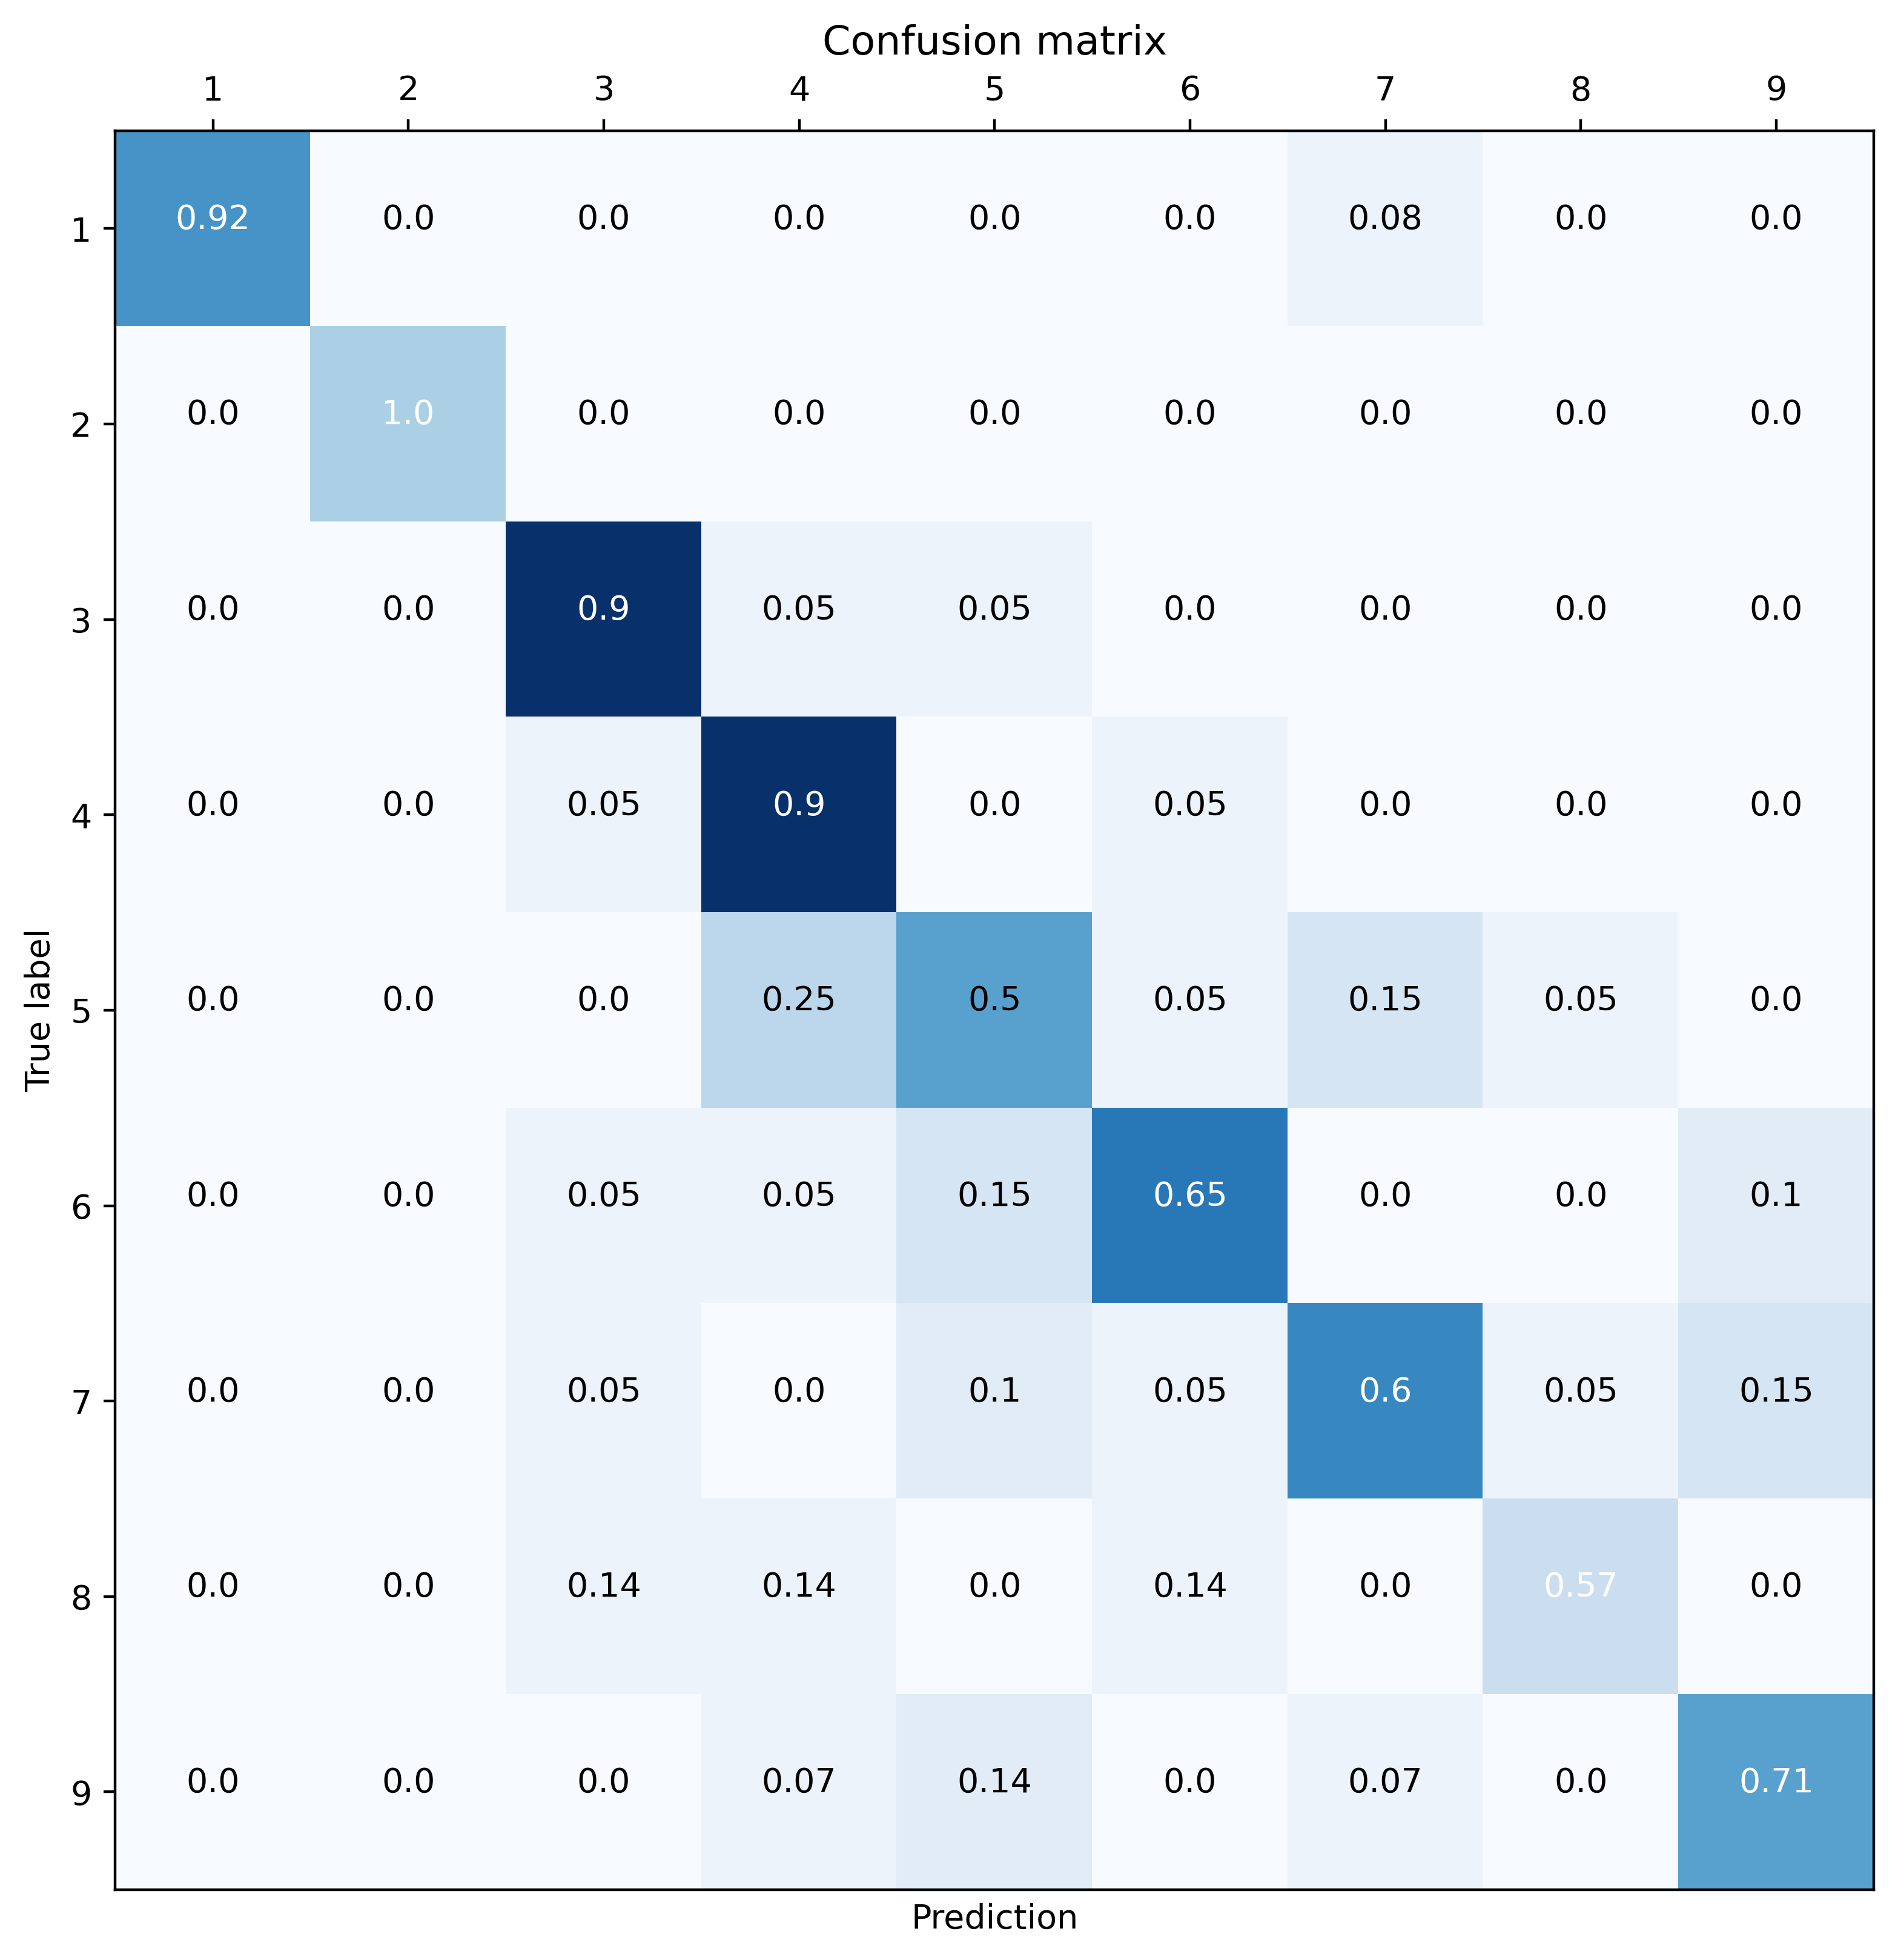

In [8]:
# confusion_matrix(labels=labels1D_test, predictions=ptest, class_names=[3, 4, 5, 6, 7])
confusion_matrix(labels=labels1D_test, predictions=ptest, class_names=np.arange(1,10,1).tolist())

In [9]:
# m = tf.keras.metrics.SparseCategoricalAccuracy()
# m.update_state(labels1D_test.reshape(1,100).shape, ptest.reshape(1,100).shape)
# m.result().numpy()

In [10]:
from sklearn.metrics import accuracy_score
mse = accuracy_score(y_true=labels1D_test, y_pred=ptest)
mse
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
# print (test_accuracy(labels1D_test.reshape(labels1D_test.shape[0],1), ptest.reshape(ptest.shape[0],1)))

0.7338129496402878

<Figure size 4800x4000 with 0 Axes>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 4800x4000 with 0 Axes>

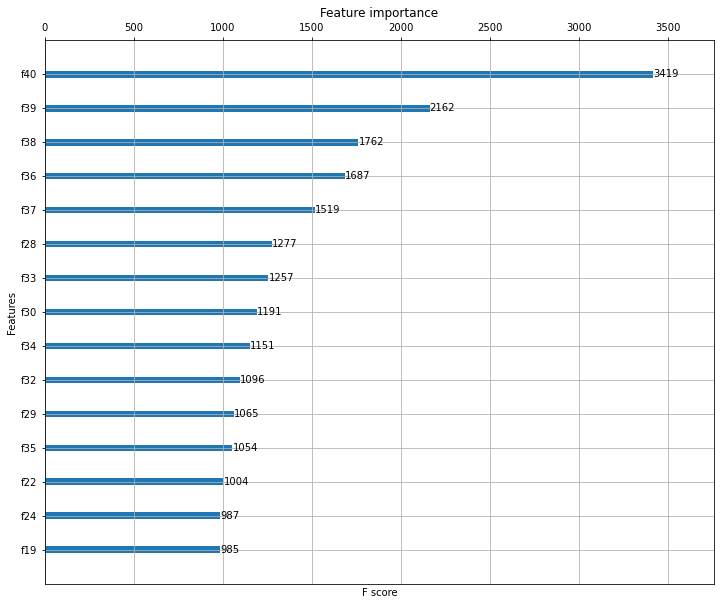

In [11]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,10
plt.figure(dpi=400)
xgb.plot_importance(bst, max_num_features=15)

<Figure size 32000x20000 with 0 Axes>

<AxesSubplot:>

<Figure size 32000x20000 with 0 Axes>

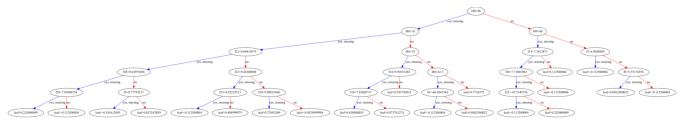

In [12]:
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 80,50
plt.figure(figsize=(80, 50), dpi=400)
xgb.plot_tree(bst, num_trees=5)

In [13]:
element_flatten2D_test[:,-1]
labels1D_test
ptest

array([ 2.,  1., 23., 72., 78.,  8.,  2.,  2., 69., 59.,  1.,  1., 66.,
       72., 61., 78., 59.,  6., 78.,  2.,  2., 59.,  2., 72.,  2., 37.,
       37., 72., 78., 61.,  1., 28.,  2.,  1., 69., 72.,  2., 78., 78.,
       78.,  2., 14., 78.,  1.,  1.,  2.,  1., 78., 37., 78., 51., 78.,
       11., 61.,  4.,  1., 78.,  1., 11., 37.,  2.,  2.,  1., 59., 72.,
        2.,  4.,  2., 78., 59., 72., 72., 72., 67.,  1., 69.,  1., 72.,
        2., 72., 23., 80., 23., 78.,  2.,  2., 46., 72., 72.,  2., 78.,
        2.,  4.,  4.,  1., 65.,  2.,  1., 59.,  2., 78.,  2., 23.,  1.,
       72., 23., 72.,  2.,  2., 23.,  2., 78.,  1., 78., 23., 23., 72.,
        1.,  1., 23., 61.,  4.,  2., 23., 51., 23.,  2., 69., 69., 78.,
       55., 78.,  2.,  2., 72., 69., 23., 23., 72.])

array([8, 4, 5, 8, 8, 0, 4, 6, 2, 2, 4, 4, 6, 8, 0, 6, 2, 0, 2, 4, 4, 2,
       6, 3, 3, 0, 0, 6, 6, 6, 5, 7, 7, 5, 2, 1, 8, 6, 6, 2, 3, 1, 8, 4,
       2, 4, 4, 8, 7, 6, 0, 3, 6, 0, 8, 8, 2, 5, 7, 0, 2, 3, 2, 2, 6, 6,
       8, 5, 6, 2, 6, 8, 4, 4, 3, 1, 3, 6, 3, 4, 5, 0, 5, 2, 7, 4, 5, 8,
       4, 1, 4, 4, 8, 8, 3, 5, 3, 4, 2, 4, 3, 3, 5, 7, 3, 5, 6, 3, 2, 5,
       7, 3, 6, 3, 5, 5, 3, 4, 4, 3, 0, 0, 2, 5, 0, 5, 5, 1, 1, 6, 6, 3,
       3, 5, 2, 2, 5, 5, 2])

array([4., 4., 5., 8., 8., 0., 5., 6., 2., 2., 7., 4., 6., 8., 0., 6., 4.,
       0., 2., 3., 3., 2., 5., 3., 3., 0., 0., 2., 6., 6., 8., 7., 7., 4.,
       2., 1., 4., 6., 8., 2., 3., 1., 8., 4., 2., 4., 4., 8., 5., 6., 0.,
       3., 7., 0., 8., 3., 2., 4., 7., 0., 2., 3., 3., 2., 6., 6., 8., 4.,
       6., 2., 6., 6., 3., 6., 3., 1., 3., 8., 2., 4., 5., 0., 5., 2., 7.,
       4., 5., 8., 6., 1., 3., 3., 8., 8., 3., 2., 3., 4., 2., 4., 3., 3.,
       5., 3., 3., 5., 8., 3., 2., 5., 2., 3., 4., 3., 5., 5., 3., 6., 4.,
       5., 0., 6., 2., 5., 0., 5., 8., 1., 1., 6., 4., 3., 3., 3., 2., 2.,
       5., 5., 2.], dtype=float32)

In [14]:
# np.unique(element_flatten2D_test[:,-1])

In [15]:
def get_one_hot(targets, nb_classes=81):
    ## number of layer group = 80, zero shifting ==> 80+1
    targets = targets.astype(int)
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [16]:
# element_flatten2D_test[:,-1]
# element_flatten2D_train[:,-1]
# np.concatenate((element_flatten2D_test[:,-1], element_flatten2D_train[:,-1]), axis=0)

In [17]:
import pandas as pd
df = pd.DataFrame({"layergroup":element_flatten2D_test[:,-1].astype(int),
                   "label": labels1D_test,
                   "predict": ptest.astype(int)})

df_train = pd.DataFrame({"layergroup":element_flatten2D_train[:,-1].astype(int),
                   "label": labels1D_train,
                   "predict": ptrain.astype(int)})

df_all = pd.DataFrame({"layergroup":np.concatenate((element_flatten2D_test[:,-1], element_flatten2D_train[:,-1]), axis=0).astype(int),
                   "label": np.concatenate((labels1D_test, labels1D_train), axis=0).astype(int),
                   "predict": np.concatenate((ptest, ptrain), axis=0).astype(int)})

df = df_all

In [18]:
label_lg_matrix = np.zeros([9,81])
# df.loc[df["label"] == 1, "layergroup"].tolist()
# df = df.loc[(df["label"] != df["predict"])]

for layernumber in np.arange(9):
    print(layernumber)
    layergroup_onehot = get_one_hot(np.array(df.loc[df["label"] == layernumber, "layergroup"].tolist()))
    label_lg_matrix[layernumber] = np.sum(layergroup_onehot, axis=0)

0
1
2
3
4
5
6
7
8


In [19]:
df_label_lg = pd.DataFrame(label_lg_matrix.astype(int))
df_label_lg.index += 1
df_label_lg = df_label_lg.loc[:, (df_label_lg != 0).any(axis=0)]
df_label_lg

,1,2,4,6,8,9,11,14,15,17,...,66,67,68,69,71,72,74,78,79,80
1,0,0,2,5,7,1,0,0,0,0,...,0,0,0,1,0,0,0,12,0,9
2,1,9,0,0,0,0,3,3,1,0,...,0,0,0,17,0,8,0,2,0,0
3,9,12,2,0,1,0,1,0,0,0,...,1,0,2,27,10,23,0,29,3,1
4,18,65,0,0,1,0,3,0,0,0,...,0,0,1,4,0,33,0,30,0,0
5,56,47,2,0,14,1,0,0,0,0,...,1,2,0,2,1,15,1,7,0,0
6,14,21,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
7,24,26,2,1,1,0,5,1,0,0,...,6,0,0,7,0,44,0,37,0,0
8,19,24,0,0,1,0,3,0,3,0,...,0,0,0,0,0,0,0,0,0,0
9,21,8,16,0,6,0,1,0,0,0,...,0,0,0,1,0,42,0,21,0,0


Text(87.0, 0.5, 'layer number')

Text(0.5, 86.0, 'layer group')

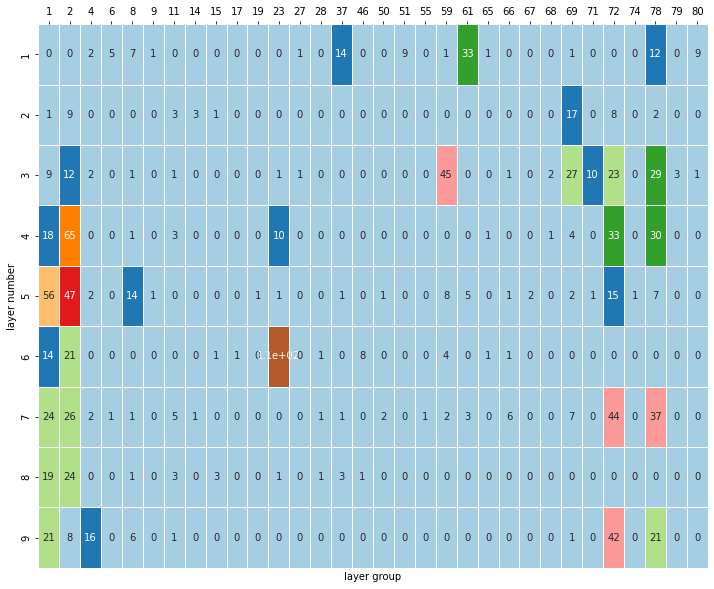

In [20]:
import seaborn as sns
import matplotlib.pylab as plt

# mask = np.zeros_like(df_label_lg)
# mask[np.triu_indices_from(mask)] = True
cmap = sns.color_palette("Paired")
ax = sns.heatmap(df_label_lg, linewidth=0.5, annot=True, cbar=False, cmap=cmap)
ax.set_ylabel("layer number")
ax.set_xlabel("layer group")
plt.show()

In [4]:
avid = ("sfsf")
avid.split()
url = f"https://jable.tv/videos/{avid}/"

In [5]:
url

'https://jable.tv/videos/sfsf/'